In this part we want to obtain the GO terms for the protein family our model obtained

In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import re
import time
from tqdm.notebook import tqdm
import json

from requests.adapters import HTTPAdapter, Retry

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET

### Task 1 - GO annotations from UniProt

In [3]:
id_mapping_url = '/idmapping/run'
base_url = 'https://rest.uniprot.org'

def check_response(response):
    try:
        response.raise_for_status()
    except requests.HTTPError:
        print(response.json())
        raise

POLLING_INTERVAL = 3

def check_id_mapping_results_ready(job_id):
    while True:
        request = requests.get(f"{base_url}/idmapping/status/{job_id}")
        check_response(request)
        j = request.json()
        if "jobStatus" in j:
            if(j["jobStatus"] == "RUNNING"):
                print(f"Retrying in {POLLING_INTERVAL}s")
                time.sleep(POLLING_INTERVAL)
            else:
                raise Exception(j['jobStatus'])
        else:
            return bool(j['results'] or j['failedIds'])
        
def get_next_link(headers):
    if "Link" in headers:
        re_next_link = re.compile(r'<(.+)>; rel="next"')
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)

def get_batch(batch_url, session):
    while batch_url:
        response = session.get(batch_url)
        response.raise_for_status()
        total = response.headers["x-total-results"]
        yield response, total
        batch_url = get_next_link(response.headers)

def map_names_to_ids(hmm_accs):
    ''' Maps UniProt names to ids, for example LRC15_RAT -> Q8R5M3.
        Returns a dict. '''
    # Create a mapping job
    ids = ','.join(list(hmm_accs))
    r = requests.post(f"{base_url}/idmapping/run", params={'from': 'UniProtKB_AC-ID', 
                                                            'to': 'UniProtKB',
                                                            'ids': ids})
    
    job = r.json()
    print('Request made. Job id: {}'.format(job))
    
    retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
    session = requests.Session()
    session.mount("https://", HTTPAdapter(max_retries=retries))

    
    if check_id_mapping_results_ready(job['jobId']):
        print('Result ready')
        jobId = job['jobId']
        url = f'{base_url}/idmapping/details/{jobId}'
        res1 = session.get(url).json()
        url2 = res1['redirectURL']

        mappings = []
        failed = []
        count = 0
        print('Starting to retrieve results')
        for batch, total in get_batch(url2, session):
            results = batch.json()['results']
            try:
                failed = batch.json()['failedIds']
            except:
                faled = []
            mappings.extend(results)
            failed.extend(failed)
            count+=len(results)
            print(f'{count} / {total}')
            
        hmm_accs_mapped = {m['from']:m['to']['primaryAccession'] for m in mappings}
        print('Finished retrieving results')
        return hmm_accs_mapped
    else:
        print('Results not ready')

In [4]:
def get_uniprot_xml(prot_acc):
    url = f"https://www.uniprot.org/uniprot/{prot_acc}.xml"
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Failed to retrieve UniProt XML data for {protein_accession}")

In [5]:
def extract_go_annotations(prot_acc):
    xml_data = get_uniprot_xml(prot_acc)
    # Initializing a parser for xml data
    soup = BeautifulSoup(xml_data, "lxml")
    go_annotations = []
    for db_reference in soup.find_all("dbreference", type="GO"):
        for property_tag in db_reference.find_all("property", type="term"):
#             print(property_tag)
#             print(db_reference['id'])
            go_annotations.append((db_reference['id'], property_tag["value"]))
    return go_annotations

In [6]:
hmm_file = '/Users/statosh/Desktop/UNIPD/1st semester/Biological Data/Final Project/models_stats/3/hmm_hits_3.tsv'
# blast_file = '/Users/statosh/Desktop/UNIPD/1st semester/Biological Data/Final Project/models_stats/1/blast_hits_1.csv'

In [7]:
hmm_df = pd.read_csv(hmm_file, sep='\t')
hmm_df = hmm_df[hmm_df['E-value']<0.03]
hmm_df.head()

,Target Name,Target Accession,Target Length,Query Name,Query Accession,Query Length,E-value,Score,Bias,Domain Index,...,Query Ali. Start,Query Ali. End,Target Ali. Start,Target Ali. End,Target Env. Start,Target Env. End,Acc,Description,Mapped PDB(s),Number of Identical Sequences
0,DJC10_MOUSE,DJC10_MOUSE,793,refined_3_clustal_blast_P07237,-,119,1.900000e-109,365.1,0.8,1,...,8,116,130,232,126,235,0.92,DnaJ homolog subfamily C member 10,3aps_B,0
1,DJC10_MOUSE,DJC10_MOUSE,793,refined_3_clustal_blast_P07237,-,119,1.900000e-109,365.1,0.8,2,...,12,116,353,450,345,453,0.76,DnaJ homolog subfamily C member 10,3aps_B,0
2,DJC10_MOUSE,DJC10_MOUSE,793,refined_3_clustal_blast_P07237,-,119,1.900000e-109,365.1,0.8,3,...,3,118,449,555,447,556,0.91,DnaJ homolog subfamily C member 10,3aps_B,0
3,DJC10_MOUSE,DJC10_MOUSE,793,refined_3_clustal_blast_P07237,-,119,1.900000e-109,365.1,0.8,4,...,8,112,557,663,554,664,0.90,DnaJ homolog subfamily C member 10,3aps_B,0
4,DJC10_MOUSE,DJC10_MOUSE,793,refined_3_clustal_blast_P07237,-,119,1.900000e-109,365.1,0.8,5,...,10,113,673,775,669,781,0.90,DnaJ homolog subfamily C member 10,3aps_B,0


In [8]:
# blast_df = pd.read_csv(blast_file, names=['query', 'subject', 'identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score', 'q_coverage'])
# blast_df[['acc', 'version']] = blast_df['subject'].str.split('.', 1, expand=True)
# blast_df = blast_df.loc[blast_df['evalue'] < 0.03]
# blast_df.head()


In [9]:
def get_all_annotations(df, flag='hmm'):
    """
    Flag could be either 'hmm' or 'blast'
    """
    if flag == 'hmm':
        all_annotations = {}
        proteins = list(df['Target Accession'])
        mapped_ids = map_names_to_ids(proteins)
        for protein in tqdm(proteins):
            if mapped_ids.get(protein):
                mapped_id = mapped_ids[protein]
    #             print(mapped_id)
                if all_annotations.get(mapped_id, None) is None:
                    annotations = extract_go_annotations(mapped_id)
                    all_annotations[mapped_id] = annotations
        return all_annotations
    
    elif flag == 'blast':
        all_annotations = {}
        proteins = list(df['acc'])
        for protein in tqdm(proteins):
            if all_annotations.get(protein, None) is None:
                annotations = extract_go_annotations(protein)
                all_annotations[protein] = annotations
        return all_annotations
    
    else:
        raise Exception('The flag passed is not correct')
    

In [10]:
# hmm_annotations = get_all_annotations(hmm_df)

In [11]:
# json = json.dumps(hmm_annotations)

# # open file for writing, "w" 
# f = open("hmm_annotations.json","w")

# # write json object to file
# f.write(json)

# # close file
# f.close()

In [12]:
with open("hmm_annotations.json") as json_file:
    hmm_annotations = json.load(json_file)

### Task 2 - enrichment

Steps:
1. Get the SwissProt XML file with all SwissProt GO terms
2. Create a matrix of our terms (proteins x terms from swissprot), where we place 1 at (x, y) if the term y is associated with protein x 
3. Follow the steps of calculating ancestors 
4. Calculate the enrichment, where you consider which terms are associated with your family and which ones are not (create a table for fisher exact test)
5. Calculate the statistics 

In [13]:
def obo_parser(obo_file, valid_rel=("is_a", "part_of")):
    """
    Parse a OBO file and returns a list of ontologies, one for each namespace.
    Obsolete terms are excluded as well as external namespaces
    """
    term_dict = {}
    term_id = None
    namespace = None
    name = None
    term_def = None
    alt_id = []
    rel = []
    obsolete = True
    with open(obo_file) as f:
        for line in f:
            line = line.strip().split(": ")
            if line and len(line) > 1:
                k = line[0]
                v = ": ".join(line[1:])
                if k == "id":
                    # Populate the dictionary with the previous entry
                    if term_id is not None and obsolete is False and namespace is not None:
                        term_dict[term_id] = {'id': term_id,
                                                                        'name': name,
                                                                       'namespace': namespace,
                                                                       'def': term_def,
                                                                       'alt_id': alt_id,
                                                                       'rel': rel}
                    # Assign current term ID
                    term_id = v

                    # Reset optional fields
                    alt_id = []
                    rel = []
                    obsolete = False
                    namespace = None

                elif k == "alt_id":
                    alt_id.append(v)
                elif k == "name":
                    name = v
                elif k == "namespace" and v != 'external':
                    namespace = v
                elif k == "def":
                    term_def = v
                elif k == 'is_obsolete':
                    obsolete = True
                elif k == "is_a" and k in valid_rel:
                    s = v.split('!')[0].strip()
                    rel.append(s)
                elif k == "relationship" and v.startswith("part_of") and "part_of" in valid_rel:
                    s = v.split()[1].strip()
                    rel.append(s)

        # Last record
        if obsolete is False and namespace is not None:
            term_dict[term_id] = {'id': term_id,
                                                          'name': name,
                                                          'namespace': namespace,
                                                          'def': term_def,
                                                          'alt_id': alt_id,
                                                          'rel': rel}
    return term_dict

In [14]:
graph_dict = obo_parser('/Users/statosh/Desktop/UNIPD/1st semester/Biological Data/Final Project/go.obo')
graph_dict['GO:0016791']

{'id': 'GO:0016791',
 'name': 'phosphatase activity',
 'namespace': 'molecular_function',
 'def': '"Catalysis of the hydrolysis of phosphoric monoesters, releasing inorganic phosphate." [GOC:curators, GOC:pg]',
 'alt_id': ['GO:0003869', 'GO:0016302'],
 'rel': ['GO:0042578', 'GO:0016311']}

In [15]:
len(graph_dict)

43791

In [16]:
# Assign indexes to terms
graph_list = np.array(list(graph_dict.values()))
graph_idx = {term_obj['id']: i for i, term_obj in enumerate(graph_list)}

print(graph_idx['GO:0016791'])
print(graph_list[graph_idx['GO:0016791']])

9296
{'id': 'GO:0016791', 'name': 'phosphatase activity', 'namespace': 'molecular_function', 'def': '"Catalysis of the hydrolysis of phosphoric monoesters, releasing inorganic phosphate." [GOC:curators, GOC:pg]', 'alt_id': ['GO:0003869', 'GO:0016302'], 'rel': ['GO:0042578', 'GO:0016311']}


In [17]:
"""
Generator function that parses GOA GAF files (https://www.ebi.ac.uk/GOA/downloads)
The generator yields a block of lines corresponding to the same protein:

UniProtKB       A0A024R1R8      hCG_2014768             GO:0002181      PMID:21873635   IBA     PANTHER:PTN002008372|SGD:S000007246     P       HCG2014768, isoform CRA_a       hCG_2014768     protein taxon:9606      20171102        GO_Central
UniProtKB       A0A024RBG1      NUDT4B          GO:0003723      GO_REF:0000037  IEA     UniProtKB-KW:KW-0694    F       Diphosphoinositol polyphosphate phosphohydrolase NUDT4B NUDT4B  protein taxon:9606      20191109        UniProt
UniProtKB       A0A024RBG1      NUDT4B          GO:0005829      GO_REF:0000052  IDA             C       Diphosphoinositol polyphosphate phosphohydrolase NUDT4B NUDT4B  protein taxon:9606      20161204        HPA
"""
def gen_block(file_name):
    with gzip.open(file_name) as f:
        name, old_name = None, None
        chunk = []
        for line in f:
            line = line.decode()
            if line and line[0] != "!":
                _, name, _, _, term, _, ec, _, namespace, protein_name = line.split("\t")[:10]
                if old_name and chunk and name != old_name:
                    yield (old_name, set(chunk))  # return a set as there can be repetitions, i.e. the same term with different evidence codes
                    chunk = []
                old_name = name
                chunk.append(term)
        # Last line
        if old_name:
            yield (old_name, set(chunk))

In [18]:
import xmltodict

The code chunk below is for creating a swiss_prot protein x terms dictionary. Takes +- 30 min, so we have saved it into a .json file for convenience.

In [22]:
# swiss_prot_terms = {}
# term_count_bio_all = np.zeros((len(graph_list), ))
# term_count_mol_all = np.zeros((len(graph_list), ))
# term_count_cell_all = np.zeros((len(graph_list), ))
# # idx = [graph_idx[term[0].replace('"', '')] for term in prot_terms[prot] if graph_dict.get(term[0].replace('"', '')) 
# # and graph_dict.get(term[0].replace('"', ''))['namespace']==namespace_given]


# with open('/Users/statosh/Desktop/UNIPD/1st semester/Biological Data/Final Project/uniprot_sprot.xml', 'r') as f:
#     idx = 0  
#     pbar = tqdm(total=183102285, initial=idx)
    
#     while idx < 183102285:
#         line = f.readline()
#         idx += 1
#         pbar.update(1)
#         line = line.strip()
# #         print(idx, repr(line))
#         if line.startswith('<accession>'):
#             line = xmltodict.parse(line)
# #             print(line)
#             protein = line['accession']
#             if hmm_annotations.get(protein, None) is None:
#                 swiss_prot_terms[protein] = swiss_prot_terms.get(protein, [])
#                 while idx < 183102285:
#                     x = f.tell()
#                     line = f.readline()
#                     idx += 1
#                     pbar.update(1)
#                     line = line.strip()
#                     if line.startswith('<accession>'):
#                         f.seek(x)
#                         idx -= 1
#                         break
#                     elif line.startswith('<dbReference type="GO"'):
#                         line_1 = line.split('id=')[-1].replace('>', '')
#                         line_1 = line_1.replace('"', '')
#                         # Counting the number of proteins 
#                         if graph_dict.get(line_1):
#                             term_idx = graph_idx[line_1]
#                             if graph_dict.get(line_1)['namespace']=='biological_process':
#                                 term_count_bio_all[term_idx] += 1
#                             elif graph_dict.get(line_1)['namespace']=='molecular_function':
#                                 term_count_mol_all[term_idx] += 1
#                             elif graph_dict.get(line_1)['namespace']=='cellular_component':
#                                 term_count_cell_all[term_idx] += 1
                            
#                         line = f.readline()
#                         idx += 1
#                         pbar.update(1)
#                         line = line.strip()
#                         if line.startswith('<property type="term"'):
#                             line_2 = line.split('value=')[-1].replace('/>', '')
#                         else:
#                             line_2 = ''
#                         tpl = (line_1, line_2)
#                         swiss_prot_terms[protein].append(tpl)

#     #                     pass
#     #                     line = xmltodict.parse(line)
#     #                     print(line)  
#     pbar.close()

  0%|          | 0/183102285 [00:00<?, ?it/s]

In [26]:
# np.save('term_count_bio_all.npy', term_count_bio_all)
# np.save('term_count_mol_all.npy', term_count_mol_all)
# np.save('term_count_cell_all.npy', term_count_cell_all)

In [19]:
# json = json.dumps(swiss_prot_terms)

# # open file for writing, "w" 
# f = open("swiss_prot_terms.json","w")

# # write json object to file
# f.write(json)

# # close file
# f.close()

In [27]:
with open("swiss_prot_terms.json") as json_file:
    swiss_prot_terms = json.load(json_file)

In [28]:
len(swiss_prot_terms)

788616

In [29]:
def calculate_protein_matrix(graph_idx, graph_dict, namespace_given, prot_terms):
    prot_dict = {}  # {accession: index}
    prot_matrix_idx = []  # proteins X terms
    c = 0
    for prot in tqdm(prot_terms):
        idx = [graph_idx[term[0].replace('"', '')] for term in prot_terms[prot] if graph_dict.get(term[0].replace('"', '')) and graph_dict.get(term[0].replace('"', ''))['namespace']==namespace_given]

      # skip proteins without any valid go term in the current namespace
        if idx:
#             print('yes')
            prot_matrix_idx.append(idx)
            prot_dict[prot] = c
            c += 1

    prot_matrix = np.zeros((len(prot_dict), len(graph_list)))
    for i, idx in enumerate(prot_matrix_idx):
        idx = np.array(idx)
        prot_matrix[i, idx] = 1
    return prot_matrix

In [30]:
# Initializing the dictionaries to store all of the GO annotations found separately for all three sub-ontologies
# Biological processes annotations
bio_processes = calculate_protein_matrix(graph_idx, graph_dict, 'biological_process', hmm_annotations)
# Molecular functions annotations
molecular_func = calculate_protein_matrix(graph_idx, graph_dict, 'molecular_function', hmm_annotations)
# Cellular components annotations
cellular_component = calculate_protein_matrix(graph_idx, graph_dict, 'cellular_component', hmm_annotations)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [31]:
# np.save('bio_processes.npy', bio_processes)
# np.save('molecular_func.npy', molecular_func)
# np.save('cellular_component.npy', cellular_component)

In [32]:
# Initializing the dictionaries to store all of the GO annotations found separately for all three sub-ontologies
# Biological processes annotations
bio_processes_all = calculate_protein_matrix(graph_idx, graph_dict, 'biological_process', swiss_prot_terms)
# Molecular functions annotations
molecular_func_all = calculate_protein_matrix(graph_idx, graph_dict, 'molecular_function', swiss_prot_terms)
# Cellular components annotations
cellular_component_all = calculate_protein_matrix(graph_idx, graph_dict, 'cellular_component', swiss_prot_terms)

  0%|          | 0/788616 [00:00<?, ?it/s]

  0%|          | 0/788616 [00:00<?, ?it/s]

  0%|          | 0/788616 [00:00<?, ?it/s]

In [26]:
# np.save('bio_processes_all.npy', bio_processes_all)

# np.save('molecular_func_all.npy', molecular_func_all)

# np.save('cellular_component_all.npy', cellular_component_all)

In [33]:
# Adjacency matrix
matrix = np.zeros((len(graph_list), len(graph_list)), dtype='bool')  # { namespace: matrix(terms x terms) ) }
for i, term_obj in enumerate(graph_list):
    for parent in term_obj['rel']:
        j = graph_idx[parent]
        if term_obj['namespace'] == graph_list[j]['namespace']:  # Skipp cross-namespace relationships
            matrix[i, j] = 1
matrix.shape

(43791, 43791)

#### Ancestors search

In [34]:
def top_sort(matrix):
    indexes = []
    visited = 0
    (rows, cols) = matrix.shape

    # create a vector containing the in-degree of each node (no. children)
    in_degree = matrix.sum(axis=0)

    # find the nodes with in-degree 0 (leaves) and add them to the queue
    queue = np.nonzero(in_degree == 0)[0].tolist()

    # for each element of the queue increment visits, add them to the list of ordered nodes
    # and decrease the in-degree of the neighbor nodes
    # and add them to the queue if they reach in-degree == 0
    while queue:
        visited += 1
        idx = queue.pop(0)
        indexes.append(idx)
        in_degree[idx] -= 1
        for j in np.nonzero(matrix[idx, :])[0]:
            in_degree[j] -= 1
            if in_degree[j] == 0:
                queue.append(j)

    # if visited is equal to the number of nodes in the graph then the sorting is complete
    # otherwise the graph can't be sorted with topological order
    if visited == rows:
        return np.array(indexes)
    else:
        raise Exception("The sparse matrix doesn't represent an acyclic graph")

In [35]:
order = top_sort(matrix)
order.size

43791

In [36]:
def propagate(prot_matrix, matrix, order):
    print('start deepest')
    deepest = np.where(np.sum(prot_matrix[:, order], axis=0) > 0)[0][0]
    print('finish deepest')
    if deepest.size == 0:
        raise Exception("The prot_matrix is empty")

    # Remove leaves
    print('start remove leaves')
    order_ = np.delete(order, [range(0, deepest)])
    print('end remove leaves')
    for i in tqdm(order_):
        # Get direct children
        children = np.where(matrix[:, i] != 0)[0]
        if children.size > 0:
            cols = np.concatenate((children, [i]))
            prot_matrix[:, i] = prot_matrix[:, cols].max(axis=1)
            
    return

In [37]:
propagate(bio_processes, matrix, order)
propagate(molecular_func, matrix, order)
propagate(cellular_component, matrix, order)

start deepest
finish deepest
start remove leaves
end remove leaves


  0%|          | 0/43787 [00:00<?, ?it/s]

start deepest
finish deepest
start remove leaves
end remove leaves


  0%|          | 0/43728 [00:00<?, ?it/s]

start deepest
finish deepest
start remove leaves
end remove leaves


  0%|          | 0/43689 [00:00<?, ?it/s]

In [32]:
# propagate(bio_processes_all, matrix, order)
# propagate(molecular_func_all, matrix, order)
# propagate(cellular_component_all, matrix, order)

#### Enrichment Fisher test

In [38]:
from scipy.stats import fisher_exact

In [39]:
graph_idx_rev = {v: k for k, v in graph_idx.items()}

In [40]:
term_count_bio = bio_processes.sum(axis=0)
term_count_bio.shape

(43791,)

In [43]:
sum(bio_processes_all[:, 1])

414.0

In [42]:
# def chunk_sum(arr, chunk_size):
#     total_sum = np.zeros((arr.shape[1], ))
#     for i in tqdm(range(0, arr.shape[0], chunk_size)):
#         chunk = arr[i:i + chunk_size, ...]
#         total_sum += chunk.sum(axis=0)
#     return total_sum

# chunk_size = 1000
# total_sum = chunk_sum(bio_processes_all, chunk_size)

In [43]:
def get_fisher_exact(inside, outside, n_proteins_inside, n_proteins_outside):
    results_left = {}
    results_right = {}
    results_two_sided = {}
    inside = inside + 1
    outside = outside + 1
    inside_withoutgo = np.repeat(n_proteins_inside+1, len(inside)) - inside + 1
    outside_withoutgo = np.repeat(n_proteins_outside+1, len(inside)) - outside + 1
    tables = {}
    
    for term in tqdm(range(len(inside))):
        table = np.array([[inside[term], inside_withoutgo[term]], [outside[term], outside_withoutgo[term]]])
#         print(table)
        tables[term] = table
        results_left[term] = fisher_exact(table, alternative='less')
        results_right[term] = fisher_exact(table, alternative='greater')
        results_two_sided[term] = fisher_exact(table, alternative='two-sided')
    
    return tables, results_left, results_right, results_two_sided


In [44]:
def enrichment_calc(term_count_all, all_proteins, my_proteins, chunk_size = 1000):
    graph_idx_rev = {v: k for k, v in graph_idx.items()}

    # Term count in my proteins
    term_count = my_proteins.sum(axis=0)
#     term_count_all = chunk_sum(bio_processes_all, chunk_size)
#     print(term_count, term_count_all)
    
    # Fraction iside my proteins
    term_ratio_inside = term_count / my_proteins.shape[0] 
    
    # Fraction in the proteins
    term_ratio_outside = term_count_all / all_proteins.shape[0]
    
    # Calculate fold increase
    term_fold_increase = np.divide(term_ratio_inside, term_ratio_outside, out=np.ones_like(term_ratio_outside), where=term_ratio_outside!=0)
    
    tables, results_left, results_right, results_two_sided = get_fisher_exact(term_count, 
                                                                          term_count_all, 
                                                                          my_proteins.shape[0], 
                                                                          all_proteins.shape[0])
    
    counter = 0
    counter_1 = 0
    significant = {}
    for i in range(len(results_right)):
        if term_count[i] > 0:
            counter_1 += 1
        if results_right[i][0] > 1 and term_count[i] > 0 and results_right[i][1] < 0.05:
            counter += 1
            significant[i] = [tables[i], results_right[i][1], graph_idx_rev[i], graph_list[i]['namespace'], graph_list[i]['id'], graph_list[i]['name']]

    significant_sorted = sorted(significant.items(), key = lambda x: x[1][1])
    
    return tables, results_left, results_right, results_two_sided, significant_sorted
    

In [48]:
tables_bio, results_left_bio, results_right_bio, results_two_sided_bio, significant_sorted_bio = enrichment_calc(term_count_bio_all, bio_processes_all, bio_processes)



  0%|          | 0/43791 [00:00<?, ?it/s]

In [49]:
tables_mol, results_left_mol, results_right_mol, results_two_sided_mol, significant_sorted_mol = enrichment_calc(term_count_mol_all, 
                                                                                                                 molecular_func_all, 
                                                                                                                 molecular_func)



  0%|          | 0/43791 [00:00<?, ?it/s]

In [50]:
tables_cell, results_left_cell, results_right_cell, results_two_sided_cell, significant_sorted_cell = enrichment_calc(term_count_cell_all, 
                                                                                                                 cellular_component_all, 
                                                                                                                 cellular_component)



  0%|          | 0/43791 [00:00<?, ?it/s]

In [51]:
for j in range(10):
    print(j+1, 
          round(significant_sorted_bio[j][1][1], 3), 
          round(results_left_bio[significant_sorted_bio[j][0]][-1], 3), 
          round(results_two_sided_bio[significant_sorted_bio[j][0]][-1], 3), 
          significant_sorted_bio[j][1][2], 
         significant_sorted_bio[j][1][3],
         significant_sorted_bio[j][1][5])

1 0.0 1.0 0.0 GO:0008150 biological_process biological_process
2 0.0 1.0 0.0 GO:0009987 biological_process cellular process
3 0.0 1.0 0.0 GO:0016043 biological_process cellular component organization
4 0.0 1.0 0.0 GO:0044085 biological_process cellular component biogenesis
5 0.0 1.0 0.0 GO:0050789 biological_process regulation of biological process
6 0.0 1.0 0.0 GO:0050794 biological_process regulation of cellular process
7 0.0 1.0 0.0 GO:0065007 biological_process biological regulation
8 0.0 1.0 0.0 GO:0071840 biological_process cellular component organization or biogenesis
9 0.0 1.0 0.0 GO:0022607 biological_process cellular component assembly
10 0.0 1.0 0.0 GO:0050896 biological_process response to stimulus


In [52]:
for j in range(10):
    print(j+1, 
          round(significant_sorted_mol[j][1][1], 3), 
          round(results_left_mol[significant_sorted_mol[j][0]][-1], 3), 
          round(results_two_sided_mol[significant_sorted_mol[j][0]][-1], 3), 
          significant_sorted_mol[j][1][2], 
         significant_sorted_mol[j][1][3],
         significant_sorted_mol[j][1][5])

1 0.0 1.0 0.0 GO:0003674 molecular_function molecular_function
2 0.0 1.0 0.0 GO:0003824 molecular_function catalytic activity
3 0.0 1.0 0.0 GO:0015035 molecular_function protein-disulfide reductase activity
4 0.0 1.0 0.0 GO:0015036 molecular_function disulfide oxidoreductase activity
5 0.0 1.0 0.0 GO:0016491 molecular_function oxidoreductase activity
6 0.0 1.0 0.0 GO:0016667 molecular_function oxidoreductase activity, acting on a sulfur group of donors
7 0.0 1.0 0.0 GO:0016860 molecular_function intramolecular oxidoreductase activity
8 0.0 1.0 0.0 GO:0016864 molecular_function intramolecular oxidoreductase activity, transposing S-S bonds
9 0.0 1.0 0.0 GO:0140096 molecular_function catalytic activity, acting on a protein
10 0.0 1.0 0.0 GO:0003756 molecular_function protein disulfide isomerase activity


In [53]:
for j in range(10):
    print(j+1, 
          round(significant_sorted_cell[j][1][1], 3), 
          round(results_left_cell[significant_sorted_cell[j][0]][-1], 3), 
          round(results_two_sided_cell[significant_sorted_cell[j][0]][-1], 3), 
          significant_sorted_cell[j][1][2], 
         significant_sorted_cell[j][1][3],
         significant_sorted_cell[j][1][5])

1 0.0 1.0 0.0 GO:0005575 cellular_component cellular_component
2 0.0 1.0 0.0 GO:0005622 cellular_component intracellular anatomical structure
3 0.0 1.0 0.0 GO:0012505 cellular_component endomembrane system
4 0.0 1.0 0.0 GO:0031974 cellular_component membrane-enclosed lumen
5 0.0 1.0 0.0 GO:0043226 cellular_component organelle
6 0.0 1.0 0.0 GO:0043227 cellular_component membrane-bounded organelle
7 0.0 1.0 0.0 GO:0043229 cellular_component intracellular organelle
8 0.0 1.0 0.0 GO:0043231 cellular_component intracellular membrane-bounded organelle
9 0.0 1.0 0.0 GO:0043233 cellular_component organelle lumen
10 0.0 1.0 0.0 GO:0070013 cellular_component intracellular organelle lumen


In [42]:
# def generate_protein_matrix(graph_dict, graph_idx, swiss_prot_terms, family_terms):
#     n = len(family_terms)
#     # Amount of go terms in general
#     go_terms = set()
    
#     for prot in swiss_prot_terms:
#         for term in swiss_prot_terms[prot]:
#             print(term[0])
#             go_terms.add(term[0])
#     m = len(go_terms)
    

### Task 3 - Form a word cloud 

Steps:
1. Install a wordcould library
2. Gather all of the enriched terms from Task 2
3. Plot a word cloud with the enriched terms
4. Plot a word could with enriched terms from higher branches (so keep an eye on the ancestors as well)

In [60]:
wordcloud_dict_bio = {}
i = 0
term_count = bio_processes.sum(axis=0)
while True:
    if significant_sorted_bio[i][1][1] > 4e-100:
        break
    term = significant_sorted_bio[i][1][2]
    term_idx = graph_idx[term]
    wordcloud_dict_bio[significant_sorted_bio[i][1][5]] = term_count[term_idx]
    i += 1
    
# wordcloud_dict_bio
# remove subontology names

{'biological_process': 369.0,
 'cellular process': 335.0,
 'cellular component organization': 123.0,
 'cellular component biogenesis': 106.0,
 'regulation of biological process': 134.0,
 'regulation of cellular process': 130.0,
 'biological regulation': 157.0,
 'cellular component organization or biogenesis': 123.0,
 'cellular component assembly': 106.0,
 'response to stimulus': 132.0,
 'response to stress': 104.0,
 'protein-containing complex subunit organization': 86.0,
 'cellular protein-containing complex assembly': 82.0,
 'regulation of biological quality': 93.0,
 'cellular response to stress': 82.0,
 'homeostatic process': 85.0,
 'cellular homeostasis': 85.0,
 'cellular response to stimulus': 93.0,
 'cellular metabolic process': 64.0,
 'multicellular organismal process': 51.0,
 'protein-containing complex assembly': 86.0,
 'primary metabolic process': 57.0,
 'organonitrogen compound metabolic process': 53.0,
 'cell redox homeostasis': 77.0,
 'macromolecule metabolic process': 47.

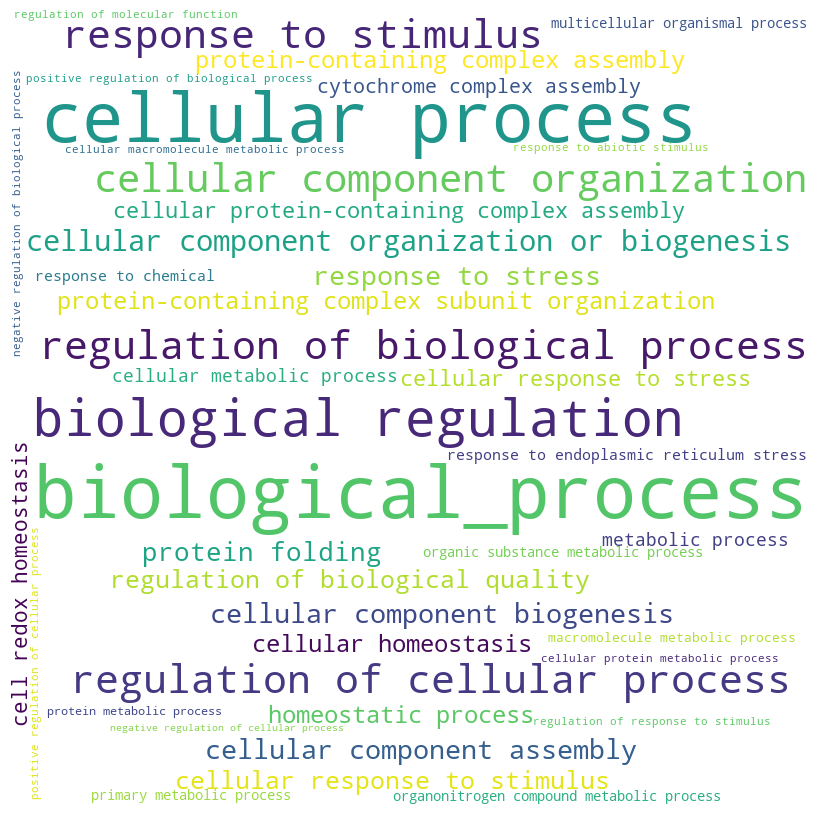

In [62]:
stopwords = set(STOPWORDS)

# comment_words = "Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum."

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(wordcloud_dict_bio)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [153]:
wordcloud_dict_mol = {}
i = 0
term_count = molecular_func.sum(axis=0)
while True:
    if significant_sorted_mol[i][1][1] > 4e-10:
        break
    term = significant_sorted_mol[i][1][2]
    term_idx = graph_idx[term]
    wordcloud_dict_mol[significant_sorted_mol[i][1][5]] = term_count[term_idx]
    i += 1
    
# wordcloud_dict_bio

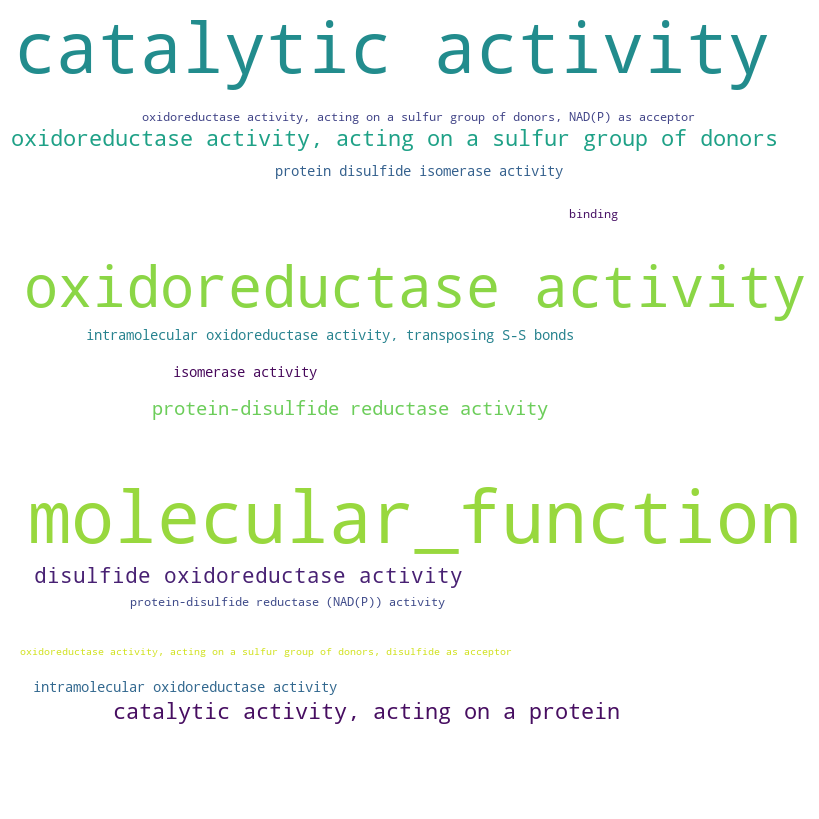

In [157]:
stopwords = set(STOPWORDS)

# comment_words = "Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum."

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(wordcloud_dict_mol)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [71]:
wordcloud_dict_cell = {}
i = 0
term_count = cellular_component.sum(axis=0)
while True:
    if significant_sorted_cell[i][1][1] > 4e-20:
        break
    term = significant_sorted_cell[i][1][2]
    term_idx = graph_idx[term]
    wordcloud_dict_cell[significant_sorted_cell[i][1][5]] = term_count[term_idx]
    i += 1
    
# wordcloud_dict_bio

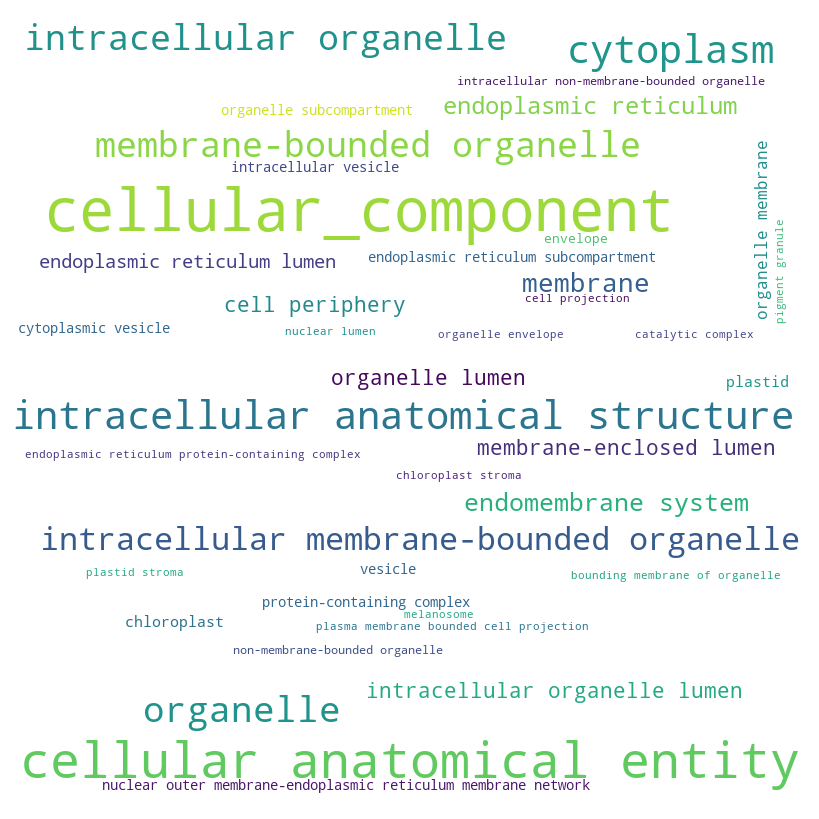

In [73]:
stopwords = set(STOPWORDS)

# comment_words = "Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum."

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(wordcloud_dict_cell)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Task 4 - hierarchically enriched branches

Steps:
1. Initialize depth first search to traverse the tree
2. Get the leaves from the set of proteins 
3. For each leaf, run the depth first search, while counting the amount of enriched terms in a branch
4. If satisfied the number > 10, then the branch is enriched

In [75]:
# Number of leaf and non-leaf (ancestor) terms
# leaves = np.argwhere(np.all(matrix == 0, axis = 0))  # leaves, col indexes where cols are all zeros. In-degree is zero
# print(len(leaves))
# print(matrix.shape[0] - len(leaves))  # ancestor terms

In [90]:
# # It can be mofied to capture the shortest path
# # https://www.geeksforgeeks.org/shortest-path-unweighted-graph/
# def breadth_first_search(matrix, node, visited, enriched, sub_ont, graph_idx_rev):
#     # Queue
#     q = [node]
#     # Set source as visited
#     visited[node] = 1
#     if graph_idx_rev.get(node) in sub_ont.keys():
#         enriched.append(node)
#     if len(enriched) > 10:
#         return
#     while q:
#         i = q.pop()
#         # For every adjacent vertex to the current vertex
#         for j in range(matrix.shape[0]):
#             if (matrix[i][j] == 1 and (not visited[j])):
#                 # Push the adjacent node in the queue
#                 q.append(j)
#                 visited[j] = 1

In [116]:
roots = np.argwhere(np.all(matrix == 0, axis = 1))  # roots, row indexes where rows are all zeros. Out-degree is zero
# print(roots)
# for root in roots:
#       print(root, graph_list[root[0]])

In [134]:
def depth_first_search(matrix, node, visited, enriched, sub_ont, graph_idx_rev):
    # Set current node as visited
    visited[node] = 1
    if graph_idx_rev.get(node) in sub_ont.keys():
        enriched.append(node)
    if len(enriched) > 10:
        return
    # For every node of the graph=
    for j in range(matrix.shape[0]):

        # If some node is adjacent to the current node and it has not already been visited
        if (matrix[node][j] == 1 and (not visited[j])):
            depth_first_search(matrix, j, visited, enriched, sub_ont, graph_idx_rev)

In [135]:
dict_bio = {}
i = 0
term_count = bio_processes.sum(axis=0)
while True:
    if significant_sorted_bio[i][1][1] > 4e-10:
        break
    term = significant_sorted_bio[i][1][2]
    term_idx = graph_idx[term]
    dict_bio[term] = term_count[term_idx]
    i += 1
    
# wordcloud_dict_bio

In [136]:
dict_mol = {}
i = 0
term_count = molecular_func.sum(axis=0)
while True:
    if significant_sorted_mol[i][1][1] > 4e-10:
        break
    term = significant_sorted_mol[i][1][2]
    term_idx = graph_idx[term]
    dict_mol[term] = term_count[term_idx]
    i += 1
    
# wordcloud_dict_bio

In [137]:
dict_cell = {}
i = 0
term_count = cellular_component.sum(axis=0)
while True:
    if significant_sorted_cell[i][1][1] > 4e-10:
        break
    term = significant_sorted_cell[i][1][2]
    term_idx = graph_idx[term]
    dict_cell[term] = term_count[term_idx]
    i += 1
    
# wordcloud_dict_bio

In [138]:
for root in roots:
    print(root[0], graph_dict[graph_idx_rev[root[0]]]['name'])

2428 molecular_function
3637 cellular_component
5345 biological_process


In [140]:
# Find children of a root
enriched_branches = []
dictionaries_enrich = [dict_mol, dict_cell, dict_bio]
# for root in roots:
# Children on the top layer
for i in range(len(roots)):
    dict_enrich = dictionaries_enrich[i]
    root = roots[i] 
    children = np.nonzero(matrix[:, root[0]])[0]
    for child in tqdm(children):
        visited = np.zeros(matrix.shape[0])
        enriched = []
        depth_first_search(matrix.T, child, visited, enriched, dict_enrich, graph_idx_rev)
        if len(enriched) > 10:
            enriched_branches.append(child)
    print(enriched_branches)

  0%|          | 0/24 [00:00<?, ?it/s]

[2473, 3598]


  0%|          | 0/3 [00:00<?, ?it/s]

[2473, 3598, 14562, 35300]


  0%|          | 0/28 [00:00<?, ?it/s]

[2473, 3598, 14562, 35300, 2, 5346, 6819, 11830, 14112, 14113, 24874, 25146, 28513]


In [147]:
enriched_branches_mol = [2473, 3598]
enriched_branches_cell = [14562, 35300]
enriched_branches_bio = [2, 5346, 6819, 11830, 14112, 14113, 24874, 25146, 28513]

In [148]:
for i in enriched_branches_mol:
    print(graph_dict[graph_idx_rev[i]]['name'])

catalytic activity
binding


In [149]:
for i in enriched_branches_cell:
    print(graph_dict[graph_idx_rev[i]]['name'])

protein-containing complex
cellular anatomical entity


In [150]:
for i in enriched_branches_bio:
    print(graph_dict[graph_idx_rev[i]]['name'])

reproduction
metabolic process
cellular process
reproductive process
multicellular organismal process
developmental process
response to stimulus
localization
biological regulation


In [146]:
children = np.nonzero(matrix[:, roots[0][0]])[0]
children

array([ 2465,  2473,  3464,  3471,  3598,  8893, 13074, 17876, 20066,
       20761, 21155, 26505, 26506, 32199, 33208, 35674, 35678, 35731,
       35790, 35798, 35932, 35958, 36069, 36099])

In [ ]:
children = np.nonzero(matrix[:, roots[0][0]])[0]
children